In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import imutils
import csv

from sklearn.externals import joblib

knnClassifier = joblib.load('filename.pk1')
svmClassifier = joblib.load('finalized_model.sav')

In [2]:
# read ground truth localization values

ground_truth_id = []
ground_truth_class = []
ground_truth_coordinates = []

with open('MIO-TCD-Localization/gt_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        ground_truth_id.append(row[0])
        ground_truth_class.append(row[1])
        coordinates = list(map(int,[row[2],row[3],row[4],row[5]]))
        ground_truth_coordinates.append(coordinates)
        
        if line_count == 0:
            line_count += 1
        else:
            line_count += 1
    print("rows read ", line_count)
            
ground_truth_id = np.array(ground_truth_id)
ground_truth_class = np.array(ground_truth_class)
ground_truth_coordinates = np.array(ground_truth_coordinates)

rows read  351549


In [3]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures

In [4]:
def calculate_dice_coefficient(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return dice coefficient based on intersection of union
    dice_coefficient = (2 * iou)/(iou + 1)
    return dice_coefficient

In [5]:
# extract images from localization
def extract_localization_images(path, extracted_images, extracted_value, image_ids):
    extracted_count = 0
    test_count = 0
    
    ## resize images to 128x128 grayscale 
    for file in os.listdir(path):
    # grab only 1 images from train directory for testing purposes 
        if (extracted_count < extracted_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(path + "/" + '00000004.jpg')), cv2.COLOR_BGR2GRAY)
            #img = cv2.resize(img,(128,128))
            extracted_images.append(img)
            extracted_count = extracted_count + 1 
            image_ids.append(""+file[:-4])
            
        else:
            break
                            
    return extracted_images


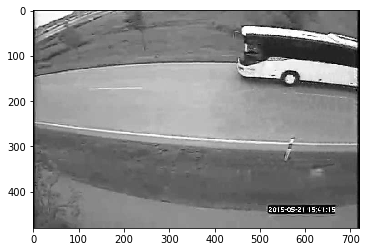

In [6]:
training_set_path= r"./MIO-TCD-Localization/train"
train_images = []
train_value = 1
image_ids = []

extract_localization_images(training_set_path, train_images, train_value,image_ids)

plt.imshow(train_images[0], cmap = "gray")



In [7]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [8]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
 
        # yield the next image in the pyramid
        yield image

In [9]:
def draw_gt_values(img, class_coordinates):
    
    for coordinates in class_coordinates:
        print(coordinates)
        xy = (int(coordinates[0]), int(coordinates[1]))
        w = int(coordinates[2])
        h = int(coordinates[3])
        #print(xy,w,h)
        cv2.rectangle(img, xy, (w,h), (0,255,0), 2)
    

In [10]:
def get_ground_truth_values(image_id):
    classes = ground_truth_class[ground_truth_id == image_id]
    class_coordinates = ground_truth_coordinates[ground_truth_id == image_id]
    return classes, class_coordinates

#### KNN LOCALIZATION

In [ ]:
# size of windows to use 
winW = 64
winH = 64

patches = []
patches_coordinates = []
patches_classes = []

# loop over the image pyramid
for resized in pyramid(train_images[0], scale=1.5):
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=24, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
         
        window_hog_features = getHogFeatures([window])
        prediction = knnClassifier.predict(window_hog_features)
        
        if (prediction != "background"):
            patches.append(window)
            patches_coordinates.append([x,y,x+winW,y+winH])
            patches_classes.append(prediction)

print("MULTISCALE KNN SLIDING WINDOW DONE")
   


In [ ]:
image_id = '00000004'
img = cv2.imread(r"./MIO-TCD-Localization/train/00000004.jpg")
gt_classes, gt_class_coordinates = get_ground_truth_values(image_id)

In [ ]:
# TESTING KNN CLASSIFIER 
print(len(patches))
print(len(patches_coordinates))
patches_classes = np.array(patches_classes)
#print(patches_classes)
print(gt_classes)
print(gt_class_coordinates)
draw_gt_values(img, gt_class_coordinates)

for box_coordinates in patches_coordinates:
    x,y = box_coordinates[0],box_coordinates[1]
    cv2.rectangle(img,(box_coordinates[0],box_coordinates[1]), (box_coordinates[2],box_coordinates[3]), (255,0,0), 2) 
    
plt.imshow(img)

In [ ]:
from scipy.spatial import distance

# ignore all the false positives and attempt to pick closest distance.

dice_coefficient_values = []
for gt_class, gt_coordinates in zip(gt_classes, gt_class_coordinates):
    closest_coordinates = []
    for patch, p_coordinates in zip(patches, patches_coordinates):
        distance_from_gt = distance.euclidean(p_coordinates, gt_coordinates)
        closest_coordinates.append(distance_from_gt)
    
    closest_coordinates = np.array(closest_coordinates)
    min_index = np.argmin(closest_coordinates)
    min_coordinates = patches_coordinates[min_index]
    dice_coefficient = calculate_dice_coefficient(min_coordinates, gt_coordinates)
    dice_coefficient_values.append(dice_coefficient)
    print(dice_coefficient)
    print("Predicted as : ", patches_classes[min_index])
    
    cv2.rectangle(img,(min_coordinates[0],min_coordinates[1]), (min_coordinates[2],min_coordinates[3]), (0,0,255), 2) 
    
    
mean_dice_coefficient = np.mean(dice_coefficient_values)
print("MEAN_DICE_COEFFICIENT : ", mean_dice_coefficient)
plt.imshow(img)
    
    
        
    

### SVM LOCALIZATION

In [88]:
# size of windows to use SVM CLASSIFIER 
winW = 80
winH = 80

patches = []
patches_coordinates = []
patches_classes = []

# loop over the image pyramid
for resized in pyramid(train_images[0], scale=1.5):
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
         
        window_hog_features = getHogFeatures([window])
        prediction = svmClassifier.predict(window_hog_features)
        
        if (prediction != 0):
            patches.append(window)
            patches_coordinates.append([x,y,x+winW,y+winH])
            patches_classes.append(prediction)

print("MULTISCALE SLIDING WINDOW DONE WITH SVM DETECTION DONE")
   

MULTISCALE SLIDING WINDOW DONE WITH SVM DETECTION DONE


36
36
['car']
[[123 103 270 168]]
[123 103 270 168]


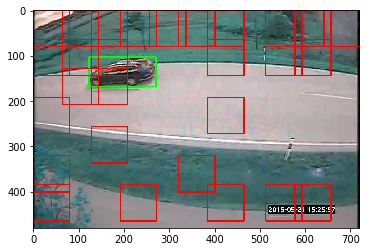

In [92]:
# TESTING SVM CLASSIFIER 
print(len(patches))
print(len(patches_coordinates))
patches_classes = np.array(patches_classes)
#print(patches_classes)
print(gt_classes)
print(gt_class_coordinates)
draw_gt_values(img, gt_class_coordinates)

for box_coordinates in patches_coordinates:
    x,y = box_coordinates[0],box_coordinates[1]
    cv2.rectangle(img,(box_coordinates[0],box_coordinates[1]), (box_coordinates[2],box_coordinates[3]), (255,0,0), 2) 
    
plt.imshow(img)

0.41668197685100133
Predicted as :  [6]
MEAN_DICE_COEFFICIENT :  0.41668197685100133


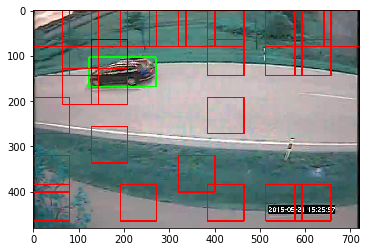

In [90]:
from scipy.spatial import distance

# ignore all the false positives and attempt to pick closest distance.

dice_coefficient_values = []
for gt_class, gt_coordinates in zip(gt_classes, gt_class_coordinates):
    closest_coordinates = []
    for patch, p_coordinates in zip(patches, patches_coordinates):
        distance_from_gt = distance.euclidean(p_coordinates, gt_coordinates)
        closest_coordinates.append(distance_from_gt)
    
    closest_coordinates = np.array(closest_coordinates)
    min_index = np.argmin(closest_coordinates)
    min_coordinates = patches_coordinates[min_index]
    dice_coefficient = calculate_dice_coefficient(min_coordinates, gt_coordinates)
    dice_coefficient_values.append(dice_coefficient)
    print(dice_coefficient)
    print("Predicted as : ", patches_classes[min_index])
    
    cv2.rectangle(img,(min_coordinates[0],min_coordinates[1]), (min_coordinates[2],min_coordinates[3]), (0,0,255), 2) 
    
    
mean_dice_coefficient = np.mean(dice_coefficient_values)
print("MEAN_DICE_COEFFICIENT : ", mean_dice_coefficient)
plt.imshow(img)